# Zu welchem Genre gehört das Filmposter

Ablauf:

1. Importieren von allen Bibliotheken
2. Einlesen der csv Datei
3. Datenbereinigung
4. Herunterladen der Bilder
5. Input Pipeline aufbauen
6. Ki Model bauen
7. Model trainieren und evaluieren
8. Exportieren & sichern des Models

In [8]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import shutil
import multiprocessing
import urllib.error
import urllib.request

from joblib import Parallel, delayed
from time import time


from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

from utils import *

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

## Laden der Daten

In [9]:
movie_data = pd.read_csv("./data/MovieGenre.csv",
                          sep=",", encoding='unicode_escape', index_col=None)
movie_data.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


## Datenbereinigung

In [10]:
# Entfernen von Null Werten
movie_data.dropna(subset=['imdbId', 'Genre', 'Poster'], inplace=True)

### Herunterladen der Daten (Parallel)

In [ ]:
def download_parallel(movies, image_dir):
    # Create list of filenames
    filenames = movies['imdbId'].apply(lambda imbdId : os.path.join(image_dir, str(imbdId)+'.jpg'))
    # Create list of image urls
    urls = movies['Poster']

    # Create destination directory
    if os.path.exists(image_dir):
        print("Directory '{}' already exists and will be deleted.".format(image_dir))
        shutil.rmtree(image_dir)
    print("Created new directory '{}'".format(image_dir))
    os.makedirs(image_dir)

    # Define function to download one single image
    def download_image(url, filename):
        try:
            urllib.request.urlretrieve(url, filename)
            return 0
        except:
            return os.path.basename(filename).split('.')[0]

    # Download images in parallel
    start = time()
    print("\nDownloading...")
    num_cores = multiprocessing.cpu_count()
    ko_list = Parallel(n_jobs=num_cores)(delayed(download_image)(u, f) for f, u in zip(filenames, urls))

    print("\nDownload in parallel mode took %d seconds." %(time()-start))
    print("Success:", len([i for i in ko_list if i==0]))
    print("Errors:", len([i for i in ko_list if i!=0]))

    # Remove not downloaded posters from the dataframe
    ko_index = movies[movies['imdbId'].isin(ko_list)].index
    movies = movies.drop(ko_index)

    return movies


destination = './data/movie-posters'
movie_data = download_parallel(movie_data, destination)

munge_dir = "./data"
if not os.path.exists(munge_dir):
    os.makedirs(munge_dir)
movie_data.to_csv(os.path.join(munge_dir, "movies.csv"), index=False)


movie_data = pd.read_csv("./munge/movies.csv")
print("Number of movie posters in last download: {}\n".format(len(movie_data)))
movie_data.head(3)

Created new directory './data/movie-posters'

Downloading...


### display Labels

## Input Pipeline aufbauen

In [ ]:
# Get label frequencies in descending order
label_freq = movies['Genre'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
movie_genre = pd.read_csv("./data/MovieGenre.csv",
                          sep=",", encoding='unicode_escape', index_col=None)
movie_genre.dropna(subset=['Genre','imdbId'], inplace=True)
movie_genre["Genre"] = movie_genre["Genre"].str.split("|")
display(movie_genre.head(4))
display(movie_genre.dtypes)
poster_urls = movie_genre['Poster']



,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,"[Animation, Adventure, Comedy]",https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,"[Action, Adventure, Family]",https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,"[Comedy, Romance]",https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,"[Comedy, Drama, Romance]",https://images-na.ssl-images-amazon.com/images...


imdbId          int64
Imdb Link      object
Title          object
IMDB Score    float64
Genre          object
Poster         object
dtype: object

Get all existing genres as list

In [3]:
def flatten(listToFlatten):
    return [item for sublist in listToFlatten for item in sublist]

genres = movie_genre["Genre"].array.tolist()
distinct_genres = list(set(flatten(genres)))
distinct_genres

['Film-Noir',
 'Comedy',
 'Biography',
 'Romance',
 'News',
 'Reality-TV',
 'History',
 'Sci-Fi',
 'Action',
 'Fantasy',
 'War',
 'Music',
 'Horror',
 'Talk-Show',
 'Western',
 'Adventure',
 'Crime',
 'Adult',
 'Game-Show',
 'Documentary',
 'Thriller',
 'Family',
 'Drama',
 'Musical',
 'Sport',
 'Mystery',
 'Short',
 'Animation']

Load Sample Images

In [4]:
import os
import cv2
samples_folder = "./data/SampleMoviePosters"
files = os.listdir(samples_folder)
sample_df = pd.DataFrame(columns=["imdbId", "img"])
sample_df.set_index("imdbId", inplace=True)
for file in files:
    id = int(file.replace(".jpg", ""))
    img = cv2.imread(os.path.join(samples_folder, file))
    scale_percent = 30  # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    sample_df.loc[id, "img"] = resized
sample_df = pd.merge(sample_df, movie_genre,
                     left_index=True, right_on="imdbId")
sample_images = []
sample_labels = []
for i in sample_df.iloc():
    sample_images.append(i["img"])
    sample_labels.append(i["Genre"])
print(sample_images[0].shape, len(sample_labels))


(80, 54, 3) 1018


Download posters

In [2]:
import os
import urllib
images_path = "./data/posters/"
mkdir_cmd = "mkdir -p " + images_path
os.system(mkdir_cmd)
failed_downloads = []
for poster in poster_urls.itertuples():
    file_name = str(poster.imdbId) + ".jpg"
    if os.path.isfile(images_path + file_name):
        continue
    try:
        resource = urllib.request.urlretrieve(
            poster.Poster, images_path + file_name)
    except:
        failed_downloads.append(str(poster.Poster))
        continue
print("Failed downloads: " + str(failed_downloads))
if len(failed_downloads) == 0:
    print("All images downloaded successfully")


In [5]:
def get_encoding_for_genre(genre):
    # if is array, assume it is a list of genres
    if isinstance(genre, list):
        return [distinct_genres.index(g) for g in genre]
    return distinct_genres.index(genre)


def get_genre_for_encoding(encoding):
    return distinct_genres[encoding]


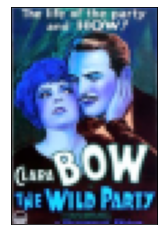

In [6]:
x = sample_images
y = sample_labels

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(x[0])
plt.xlabel(y[0], color="white")
plt.show()

# encode genre list 
y_encoded = [get_encoding_for_genre(genre) for genre in y]

In [7]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
x = x
y = y_encoded

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                           input_shape=x_train[0].shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(distinct_genres), activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)


2022-05-25 19:17:44.447491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'numpy.ndarray'>"}), (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'int\'>"})'})

Persist Model

In [25]:
model.save("./data/model")

INFO:tensorflow:Assets written to: ./data/model/assets


Load Model

In [27]:
model = tf.keras.models.load_model('./data/model')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
